# Token classification for pharmacological substances, compunds and proteins

## Introduction

Named Entity Recognition (NER) is a NLP problem that consists on classifying all the words in a sentence, assigning the corresponding label. This problem is also known as token classification. The complexity of the problem varies depending on the data we are using and how many labels we have to classify. 

For this notebook we will try to apply token classification to the [PharmaCoNER dataset](https://temu.bsc.es/pharmaconer/). This dataset contains the clinical records of patients, and the goal is to identify the different pharmacological substances, compounds and proteins in the different sequences. The content of the dataset is biomedical and medical literature that requires special preprocessing to be sure that we are conserving the context of the word and that the model is getting the right tokens when making a prediction.

In order to solve this problem, the XLM-RoBERTa model will be fine-tuned on the dataset. The XLM-RoBERTa model has been trained on 100 languages. The latter is important because the dataset is in spanish, therefore we need a model capable of make predictions on spanish text. 

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Seqeval
from seqeval.metrics import f1_score

# Scikit-Learn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# PyTorch
import torch
from torch.nn.functional import cross_entropy

# Hugging Face
from datasets import load_dataset

from transformers import (
    AutoTokenizer,
    XLMRobertaForTokenClassification,
    TrainingArguments,
    DataCollatorForTokenClassification,
    Trainer
)

/Users/mmenendezg/Developer/Books/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As established above, the model we will use is XLM-RoBERTa base. However, as tokenizer we will use the on created by the authors of the dataset. There are two reasons for this:
- 1. It has been trained to tokenize medical and biomedical corpus.
- 2. It works with text in spanish.

In [2]:
DATASET_URL = "PlanTL-GOB-ES/pharmaconer"
MODEL_NAME = "xlm-roberta-base"
TOKENIZER_NAME = "PlanTL-GOB-ES/roberta-base-biomedical-es"

# Define the device to train the model
if torch.has_mps:
    DEVICE = "mps" # For M1, M2 processors
elif torch.has_cuda:
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

BATCH_SIZE = 8

## The Dataset

Let's first load the dataset and see the labels of the tokens:

In [3]:
dataset = load_dataset(DATASET_URL)
TAGS = dataset["train"].features["ner_tags"].feature

print(TAGS)

ClassLabel(names=['O', 'B-NO_NORMALIZABLES', 'B-NORMALIZABLES', 'B-PROTEINAS', 'B-UNCLEAR', 'I-NO_NORMALIZABLES', 'I-NORMALIZABLES', 'I-PROTEINAS', 'I-UNCLEAR'], id=None)


The labels we hava are:

- `Normalizables`: Chemicals that can be manually normalized to a unique concept identifier.
- `No_Normalizables`: Chemicals that could not be normalized manually to a unique concept identifier.
- `Proteinas`: Proteins, genes, peptides, peptide hormones and antibodies.
- `Unclear`: General substances with clinical and biomedical relevance.

Let's see how many examples we have per split:

In [4]:
def get_examples_per_tag(dataset):
    list_tags = [tag for tags in dataset["ner_tags"] for tag in tags]
    tags = pd.Series(list_tags).value_counts()
    return list(tags)

[Text(0, 0, '8129'), Text(0, 0, '3787'), Text(0, 0, '3952')]

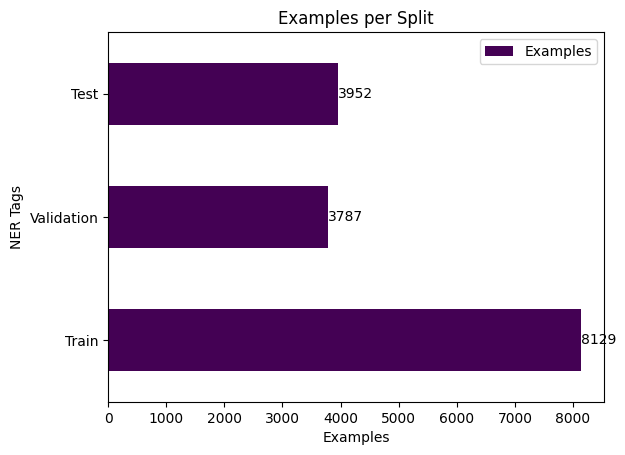

In [5]:
examples_per_split = {
    "Train": dataset["train"].num_rows,
    "Validation": dataset["validation"].num_rows,
    "Test": dataset["test"].num_rows,
}

ax = pd.DataFrame(examples_per_split, index=["Examples"]).T.plot.barh(
    title="Examples per Split", xlabel="Examples", ylabel="NER Tags", colormap="viridis"
)
ax.bar_label(ax.containers[-1])

The train split contains 8129 sequences, while the test and validation splits contain almost the same amount of examples. But this gives us just a part of the picture. We need to know what is the distribution of the lengths of these sequences:

In [7]:
list_tags = [tag for tags in dataset["train"]["ner_tags"] for tag in tags]
tags = pd.Series(list_tags).value_counts()
list(tags)

[198569, 2282, 1392, 486, 314, 88, 24, 13, 3]

In [8]:
tokens_length = [len(tokens) for tokens in dataset["train"]["tokens"]]

len_sequnces = {
    "Train": [len(tokens) for tokens in dataset["train"]["tokens"]],
    "Validation": [len(tokens) for tokens in dataset["validation"]["tokens"]],
    "Test": [len(tokens) for tokens in dataset["test"]["tokens"]],
}

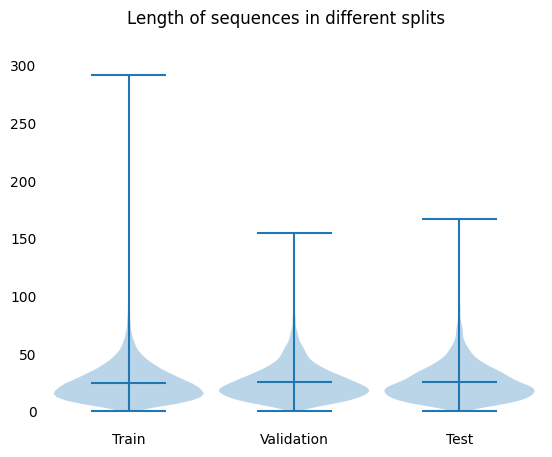

In [9]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.suptitle("Length of sequences in different splits")

for idx, split in enumerate(["Train", "Validation", "Test"]):
    ax[idx].violinplot(len_sequnces[split], showmeans=True)
    ax[idx].set_xlabel(split)
    for key, spine in ax[idx].spines.items():
        spine.set_visible(False)
    ax[idx].tick_params(
        axis="both", which="both", bottom=False, left=False, labelbottom=False
    )

plt.subplots_adjust(wspace=0)
plt.show()

The average lenght of the sequences is around 30 tokens for the three splits. There is an outlier in the train split that has almost 300 tokens. This may affect the training if we do not choose the right model. In this case the XLM-RoBERTa can handle up to 500 tokens as input, and the largest sequence should not pose a challenge for this project.

The top 10 longest sequences may give us a perspective of how many long sequences we have:

In [41]:
print(
    f"These are the lengths of the 10 longest sequences:\n\t{sorted(len_sequnces['Train'])[-10:]}"
)

These are the lengths of the 10 longest sequences:
	[124, 128, 129, 132, 135, 139, 147, 162, 184, 292]


Only one sequence is over 200 tokens.

Finally, we may want to know if the labels are balanced. This will help us decide which metrics we will use:

[Text(0, 0, '4347'),
 Text(0, 0, '2963'),
 Text(0, 0, '1120'),
 Text(0, 0, '634'),
 Text(0, 0, '166'),
 Text(0, 0, '50'),
 Text(0, 0, '25'),
 Text(0, 0, '7')]

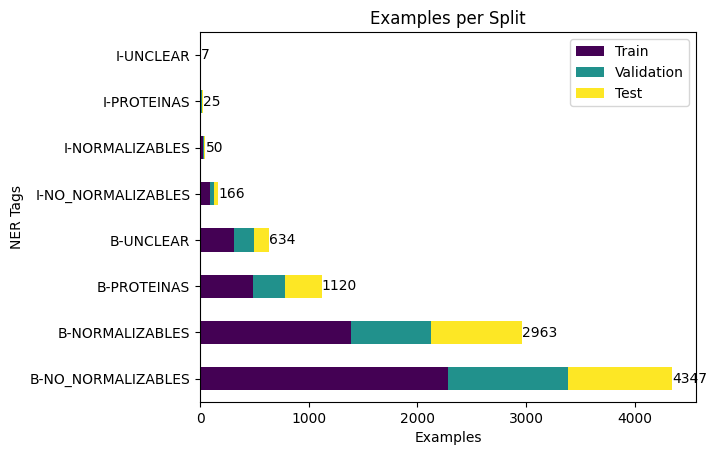

In [6]:
tags_per_class = {
    "Train": get_examples_per_tag(dataset["train"])[1:],
    "Validation": get_examples_per_tag(dataset["validation"])[1:],
    "Test": get_examples_per_tag(dataset["test"])[1:],
}

ax = pd.DataFrame(tags_per_class, index=TAGS.names[1:]).plot.barh(
    title="Examples per Split",
    xlabel="Examples",
    ylabel="NER Tags",
    stacked=True,
    colormap="viridis",
)
ax.bar_label(ax.containers[-1])

The tags are unbalanced, and using accuracy may not be suitable. F1-Score, Recall and Precision will be more suitable 

Exploring the tagging of the tokens may help us understand how the dataset is structured:

In [11]:
example = dataset["train"][64]
for key, value in example.items():
    print(f"{key}: {value}")

id: 64
tokens: ['Inicia', 'esquema', 'de', 'quimioterapia', 'con', 'vincristina', ',', 'dactinomicina', 'y', 'doxorubicina', '.']
ner_tags: [0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0]


This gives us the raw tagging, but mapping the labels from index to string will help to have a better understanding of the tagging:

In [12]:
def create_tag_token(batch):
    return {"ner_tag_name": [TAGS.int2str(idx) for idx in batch["ner_tags"]]}

In [13]:
tags_ds = dataset.map(create_tag_token)

In [14]:
example = tags_ds["train"][64]
pd.DataFrame([example["tokens"], example["ner_tag_name"]], ["Tokens", "NER Tag"])

,0,1,2,3,4,5,6,7,8,9,10
Tokens,Inicia,esquema,de,quimioterapia,con,vincristina,",",dactinomicina,y,doxorubicina,.
NER Tag,O,O,O,O,O,B-NORMALIZABLES,O,B-NORMALIZABLES,O,B-NORMALIZABLES,O


## Tokenization

We will use the `roberta-base-biomedical-es` to tokenize the sequences. This is specialized on medical and biomedical text in spanish:

In [15]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

The tokenizer uses `Byte-Pair Encoding`, as in the original RoBERTa model.

In [16]:
phrase = "Esta frase es para hacer una prueba fácil."
tokenizer(phrase).tokens()

['<s>',
 'ĠEsta',
 'Ġfrase',
 'Ġes',
 'Ġpara',
 'Ġhacer',
 'Ġuna',
 'Ġprueba',
 'ĠfÃ¡cil',
 '.',
 '</s>']

Let's create the 2 dictionaries to map between tags and indexes:

In [17]:
index2tag = {idx: tag for idx, tag in enumerate(TAGS.names)}
tag2index = {tag: idx for idx, tag in enumerate(TAGS.names)}

In [18]:
tokenized_tokens = tokenizer(dataset["train"][64]["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_tokens["input_ids"])

In [19]:
word_ids = tokenized_tokens.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Tokens,<s>,ĠInicia,Ġesquema,Ġde,Ġquimioterapia,Ġcon,Ġvin,c,ristina,"Ġ,",Ġdac,tin,omicina,Ġy,Ġdoxor,ubicina,Ġ.,</s>
Word IDs,None,0,1,2,3,4,5,5,5,6,7,7,7,8,9,9,10,None


We will use the same approach that the authors of the BERT paper followed, that is to use only the first token of each word, and ignore the rest of the tokens. For this, we will mask these additional subword tokens. The value used for this label will be `-100`. Reason? Well, the loss function `torch.nn.CrossEntropy` has an attribute `ignore_index=-100`. We could custom this value, but we will keep it as default.

In [20]:
def tokenize_dataset(batch):
    tokenized_inputs = tokenizer(
        batch["tokens"], is_split_into_words=True, truncation=True
    )

    labels = []
    for idx, label in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # We validate if it is a new word or a new token of the same word
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


def encode_dataset(dataset):
    columns = ["id", "tokens", "ner_tags"]
    return dataset.map(tokenize_dataset, batched=True, remove_columns=columns)

In [21]:
train_ds = encode_dataset(dataset["train"])
valid_ds = encode_dataset(dataset["validation"])
test_ds = encode_dataset(dataset["test"])

Map: 100%|██████████| 3952/3952 [00:00<00:00, 19739.48 examples/s]


We have now the dataset splitted, tokenized and ready for the training. This is how our dataset looks like:

In [45]:
ex_idx = 56
pd.DataFrame(
    [train_ds[ex_idx]["input_ids"], train_ds[ex_idx]["attention_mask"], train_ds[ex_idx]["labels"]],
    index=["Input IDs", "Attention Mask", "Labels"],
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Input IDs,0,9910,321,1156,8516,4987,47469,18521,9688,6987,262,3198,7934,28923,2
Attention Mask,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Labels,-100,0,-100,-100,0,0,0,0,0,0,0,0,0,0,-100


As we can see, for words with multiple tokens we have only considered the first token, the rest (if many) have the label `-100` assigned.

## Create the Model

For this problem, we will use the XLM-RoBERTa model, since it is a cross-language model that has been trained on 100 different languages, spanish included. Additionally, the base model accepts up to 512 tokens in the input sequences. This matches the requirements we have so far. The longest sequence in the training model has 292 words, it should be under 512 after tokenization. 

Let's instantiate the model and set the number of labels of the classification head to the same number of classes we have in the TAGS:

In [23]:
xlmr_model = XLMRobertaForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=TAGS.num_classes
).to(DEVICE)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### How to measure the model's performance?

Since the model performs a classification, we can use metrics such as precision, recall and f1-score. The difference is that for NER we need all the words of a sequence to be correctly classified. 

This complicates our job, but luckily we have the library `seqeval` designed with this in mind. 

`seqeval` expects, however, the predictions to be lists of lists. Therefore a new function is required to pack the predictions of the model to a format that `seqeval` accepts.

In [24]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, len_seq = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(len_seq):
            # Let's ignore the labels = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx, seq_idx]])
                example_preds.append(index2tag[label_ids[batch_idx, seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## Fine-Tune The Model

It is important to first define the training arguments to pass to the trainer:

In [25]:
num_epochs = 5
logging_steps = len(train_ds) // BATCH_SIZE
model_name = f"{MODEL_NAME}-pharmaconer"

In [26]:
training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True
)

We have set up in the training arguments that we want the model to be pushed to the hub once the training has finished, therefore we need to login to the Hugging Face Hub:

In [27]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/mmenendezg/.cache/huggingface/token
Login successful


We need to create a function to tell the Trainer how to compute the metrics on the validation set:

In [28]:
def compute_metrics(predictions):
    y_pred, y_true = align_predictions(predictions.predictions, predictions.label_ids)
    return {"f1_score": f1_score(y_true, y_pred)}

Finally, it is important to define a data collator. We will use the one provided by Transformers:

In [29]:
data_collator = DataCollatorForTokenClassification(tokenizer)

With everything ready, we can now create the trainer:

In [30]:
trainer = Trainer(
    model=xlmr_model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer
)

Once the trainer has been created, with all the arguments set up, we can start training the model. We will train the model for just 5 epoch to validate the performance:

In [31]:
trainer.train()

 20%|█▉        | 1016/5085 [20:20<57:52,  1.17it/s]  

{'loss': 0.0458, 'learning_rate': 4.000983284169125e-05, 'epoch': 1.0}


                                                     
 20%|██        | 1017/5085 [25:29<3:29:09,  3.08s/it]

{'eval_loss': 0.034431781619787216, 'eval_f1_score': 1.0, 'eval_runtime': 301.3692, 'eval_samples_per_second': 12.566, 'eval_steps_per_second': 1.573, 'epoch': 1.0}


 40%|███▉      | 2032/5085 [37:56<36:53,  1.38it/s]    

{'loss': 0.0225, 'learning_rate': 3.0019665683382496e-05, 'epoch': 2.0}


                                                     
 40%|████      | 2034/5085 [38:26<2:32:50,  3.01s/it]

{'eval_loss': 0.02540457993745804, 'eval_f1_score': 1.0, 'eval_runtime': 20.5542, 'eval_samples_per_second': 184.245, 'eval_steps_per_second': 23.061, 'epoch': 2.0}


 60%|█████▉    | 3048/5085 [50:32<22:54,  1.48it/s]  

{'loss': 0.0114, 'learning_rate': 2.002949852507375e-05, 'epoch': 3.0}


                                                     
 60%|██████    | 3051/5085 [51:03<1:40:21,  2.96s/it]

{'eval_loss': 0.020322689786553383, 'eval_f1_score': 1.0, 'eval_runtime': 20.5078, 'eval_samples_per_second': 184.662, 'eval_steps_per_second': 23.113, 'epoch': 3.0}


 80%|███████▉  | 4064/5085 [1:03:19<12:26,  1.37it/s]

{'loss': 0.0065, 'learning_rate': 1.0039331366764996e-05, 'epoch': 4.0}


                                                       
 80%|████████  | 4068/5085 [1:03:54<1:05:59,  3.89s/it]

{'eval_loss': 0.021588506177067757, 'eval_f1_score': 1.0, 'eval_runtime': 21.0323, 'eval_samples_per_second': 180.056, 'eval_steps_per_second': 22.537, 'epoch': 4.0}


100%|█████████▉| 5080/5085 [1:16:02<00:03,  1.60it/s]  

{'loss': 0.0035, 'learning_rate': 4.916420845624386e-08, 'epoch': 5.0}


                                                     
100%|██████████| 5085/5085 [1:16:36<00:00,  1.11it/s]


{'eval_loss': 0.02431812323629856, 'eval_f1_score': 1.0, 'eval_runtime': 21.0365, 'eval_samples_per_second': 180.021, 'eval_steps_per_second': 22.532, 'epoch': 5.0}
{'train_runtime': 4596.9961, 'train_samples_per_second': 8.842, 'train_steps_per_second': 1.106, 'train_loss': 0.017942733878788107, 'epoch': 5.0}


TrainOutput(global_step=5085, training_loss=0.017942733878788107, metrics={'train_runtime': 4596.9961, 'train_samples_per_second': 8.842, 'train_steps_per_second': 1.106, 'train_loss': 0.017942733878788107, 'epoch': 5.0})

In [33]:
trainer.push_to_hub(commit_message="First Training completed!")

pytorch_model.bin: 100%|██████████| 1.11G/1.11G [01:13<00:00, 15.0MB/s]   


'https://huggingface.co/mmenendezg/xlm-roberta-base-pharmaconer/tree/main/'

The model has been trained and pushed to the Hub.

## Error Analysis

In order to validate the performance of the model, we can take a look at the examples from the validation split with the highest loss. 

The first step is to create a funtion that obtains the predictions and losses for the validation set:

In [46]:
def forward_pass_with_label(batch):
    # Convert from dicts of lists to lists of dicts for the data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)
    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        # logit.size = [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

    loss = cross_entropy(output.logits.view(-1, TAGS.num_classes), labels.view(-1), reduction="none")
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss": loss, "predicted_label": predicted_label}

We can now apply this to the validation set. By mapping the set with this function we will add 2 additional columns with the predictions (labels), and the losses of the predictions. Additionally, the new set will be batched to 32 examples per batch.

In [47]:
valid_df = valid_ds.map(forward_pass_with_label, batched=True, batch_size=32)


Map: 100%|██████████| 3787/3787 [03:10<00:00, 19.92 examples/s] 


The next step is to map the ids of the tokens and labels to strings. For this, we will use the dictionary `index2tag`

In [48]:
# Add the tag for the ignored tokens
index2tag[-100] = "IGN"

valid_df = valid_df.to_pandas()
# Map the columns of the labels
valid_df["input_tokens"] = valid_df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x)
)
valid_df["predicted_label"] = valid_df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x]
)
valid_df["labels"] = valid_df["labels"].apply(
    lambda x: [index2tag[i] for i in x]
)
valid_df["loss"] = valid_df.apply(
    lambda x: x["loss"][:len(x["input_ids"])], axis=1
)
valid_df["predicted_label"] = valid_df.apply(
    lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1
)


In [49]:
valid_df = valid_df.apply(pd.Series.explode)
# Remove the labels with -100
valid_df = valid_df.query("labels != 'IGN'")
valid_df["loss"] = valid_df["loss"].astype(float).round(2)
valid_df.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,8933,1,O,0.0,O,ĠPaciente
0,11353,1,O,0.0,O,ĠvarÃ³n
0,262,1,O,0.0,O,Ġde
0,6093,1,O,0.0,O,Ġ37
0,638,1,O,0.0,O,ĠaÃ±os
0,262,1,O,0.0,O,Ġde
0,1154,1,O,0.0,O,Ġedad


In [51]:
(
    valid_df.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6,7,8
labels,I-UNCLEAR,I-NO_NORMALIZABLES,B-NO_NORMALIZABLES,I-NORMALIZABLES,B-UNCLEAR,I-PROTEINAS,B-NORMALIZABLES,B-PROTEINAS,O
count,3,8,16,184,44,299,1104,736,94612
mean,9.92,9.38,7.76,3.44,3.22,2.9,1.83,1.36,0.01
sum,29.76,75.04,124.19,632.93,141.85,868.06,2023.36,997.36,692.26


There's a clear pattern to see here: the model struggles to correctly classify the labels with lower count in the set. This is expected, since there are not many examples to look at. The model has ease when classifying proteins.

Adding more examples would improve the overall f1-score of the model. 

We can finally take a look at the confusion matrix:

In [53]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    plt.show()

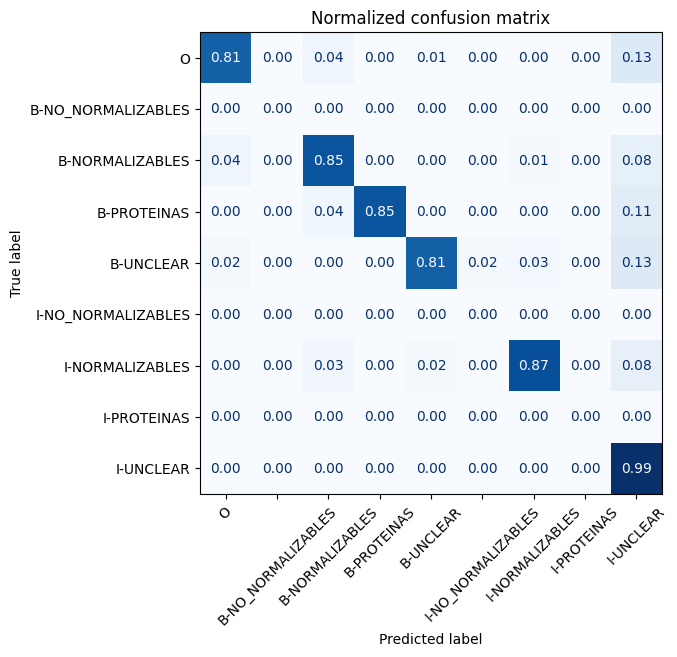

In [54]:
plot_confusion_matrix(valid_df["labels"], valid_df["predicted_label"], TAGS.names)

The model tends to generalize well with the unclear examples, but predicts a lot of other labels as unclear. 

As reference, here below is an image of the same model trained using the `xlm-roberta-base` tokenizer:

<img src="https://storage.googleapis.com/mmenendezg-ml-bucket/models/xlmr_pharmaconer/reports/images/xlmr_tokenizer_cm.png"/>

It performs better on the `UNCLEAR` AND `O` labels, but performs worst with the `NORMALIZABLES` tokens. The difference is not that bit for the rest of the tokens, maybe training the model for longer allows it to generalize better. If we need a better performance with the `PROTEINAS` or `NORMALIZABLES` my opinion is we should use the tokenizer `PlanTL-GOB-ES/roberta-base-biomedical-es`.

## References

> 1. Aitor Gonzalez Agirre et al. “Pharmaconer: Pharmacological substances, compounds and proteins named entity recognition track”. In: Proceedings of The 5th Workshop on BioNLP Open Shared Tasks. 2019, pp. 1–10.
